<a href="https://colab.research.google.com/github/tejaswishetty17/rag-from-scratch/blob/main/11_Indexing_Techniques(Multi_Representation_Indexing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

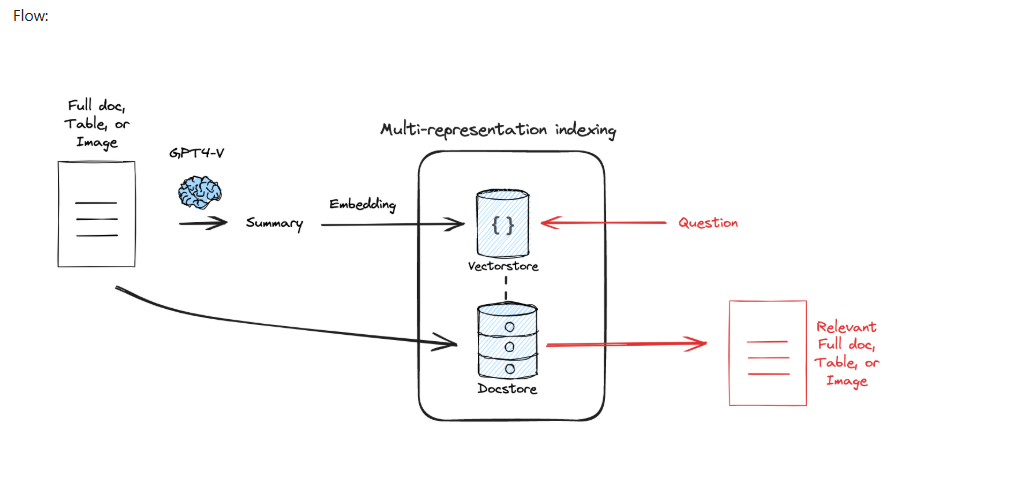

In [1]:
!pip install -q langchain_community tiktoken langchain-openai langchainhub chromadb langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.9/437.9 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.4 MB/s eta 0:00:00


In [2]:
import os
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="<API_KEY>"
os.environ["LANGCHAIN_PROJECT"]="RAG_ADVANCED"
os.environ['OPENAI_API_KEY'] = "<API_KEY>"


from langsmith import utils
utils.tracing_is_enabled()

True

In [3]:
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain.utils.math import cosine_similarity

In [4]:
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

In [8]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

chain = (
    {"doc":lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    |ChatOpenAI(model = "gpt-4o-mini", max_retries=0)
    |StrOutputParser()
)

summaries = chain.batch(docs, {"max_cocurrency":5})

In [10]:
from langchain.storage import InMemoryByteStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

#the vectorestore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings())

#The Storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

#The retriever
retriever = MultiVectorRetriever(
    vectorstore = vectorstore,
    byte_store = store,
    id_key=id_key
)
doc_ids = [str(uuid.uuid4()) for _  in docs]

#Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key:doc_ids[i]}) for i, s in enumerate(summaries)
]

#Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [11]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query, k=1)
sub_docs[0]

Document(metadata={'doc_id': '8e11c0be-687c-455e-8297-893bd4630d7b'}, page_content='The document titled "LLM Powered Autonomous Agents" by Lilian Weng presents an extensive overview of how large language models (LLMs) can be utilized to build autonomous agents capable of performing complex tasks. The key components of these agents are categorized into three main areas:\n\n1. **Planning**:\n   - **Task Decomposition**: This involves breaking down complex tasks into simpler subgoals, which can be effectively managed through techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT).\n   - **Self-Reflection**: Autonomous agents can improve by critically evaluating their past actions, which helps them refine decision-making and solve problems more efficiently.\n\n2. **Memory**:\n   - Different types of memory are discussed, including short-term and long-term memory, equated with in-context learning and external vector stores, respectively. The concept of Maximum Inner Product Search

In [14]:
retrieved_docs = retriever.invoke(query, n_results = 1)
retrieved_docs[0].page_content[0:10000]

'\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\n\n\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The